This Notebook is a Stable-diffusion tool which allows you to find similiar tokens from the SD 1.5 vocab.json that you can use for text-to-image generation. Try this Free online SD 1.5 generator with the results: https://perchance.org/fusion-ai-image-generator

Scroll to the bottom of the notebook to see the guide for how this works.

In [1]:
# @title ✳️ Load/initialize values
#Imports
#!pip install safetensors
from safetensors.torch import load_file
import json , os , shelve , torch
import pandas as pd
#----#

def my_mkdirs(folder):
  if os.path.exists(folder)==False:
    os.makedirs(folder)

def _modulus(_id,id_max):
  id = _id
  while(id>id_max):
    id = id-id_max
  return id

def getPrompts(_path, separator):
  path = _path + '/text'
  path_enc = _path + '/text_encodings'
  #-----#
  index = 0
  file_index = 0
  prompts = {}
  text_encodings = {}
  _text_encodings = {}
  #-----#
  for filename in os.listdir(f'{path}'):

    print(f'reading {filename}....')
    _index = 0
    %cd {path}
    with open(f'{filename}', 'r') as f:
      data = json.load(f)
    #------#
    _df = pd.DataFrame({'count': data})['count']
    _prompts = {
        key : value for key, value in _df.items()
    }
    for key in _prompts:
      _index = int(key)
      value = _prompts[key]

      #Read the 'header' file in the JSON
      if _index <= 0 :
        _NUM_ITEMS = int(value)
        prompts[f'{index}'] = _prompts[f'{_index}'] + separator
        index = index + 1
        continue
      if _index <= 1 :
        _file_name = f'{value}'
        %cd {path_enc}
        _text_encodings = load_file(f'{_file_name}.safetensors')
        #Store text_encodings for the header items
        text_encodings[f'{index-1}'] = _text_encodings[f'{_index-1}']
        text_encodings[f'{index}'] = _text_encodings[f'{_index}']
        #------#
        prompts[f'{index}'] = _prompts[f'{_index}'] + separator
        index = index + 1
        continue
      #------#
      #Read the text_encodings + prompts
      text_encodings[f'{index}'] = _text_encodings[f'{_index}']
      prompts[f'{index}'] = _prompts[f'{_index}'] + separator
      index = index + 1
      continue
      #-------#
    #--------#
    #_text_encodings.close() #close the text_encodings file
    file_index = file_index + 1
  #----------#
  NUM_ITEMS = index -1
  return prompts , text_encodings , NUM_ITEMS
#--------#

def append_from_url(dictA, tensA , nA , url , separator):
  dictB , tensB, nB = getPrompts(url, separator)
  dictAB = dictA
  tensAB = tensA
  nAB = nA
  for key in dictB:
    nAB = nAB + 1
    dictAB[f'{nA + int(key)}'] = dictB[key]
    tensAB[f'{nA + int(key)}'] = tensB[key]
  #-----#
  return dictAB, tensAB , nAB-1
#-------#

#🔸🔹
%cd /content/
!git clone https://huggingface.co/datasets/codeShare/text-to-image-prompts


/content
Cloning into 'text-to-image-prompts'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (492/492), done.
remote: Total 521 (delta 91), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (521/521), 2.51 MiB | 6.14 MiB/s, done.
Resolving deltas: 100% (91/91), done.
Filtering content: 100% (95/95), 305.98 MiB | 37.71 MiB/s, done.


In [ ]:
# @title ✳️ Select items for the vocab

prompt_features = True # @param {"type":"boolean","placeholder":"🦜"}
civitai_blue_set = True # @param {"type":"boolean","placeholder":"📘"}
suffix = True # @param {"type":"boolean","placeholder":"🔹"}
prefix = False # @param {"type":"boolean","placeholder":"🔸"}
emojis = True # @param {"type":"boolean","placeholder":"😃"}
debug = False

#------#
prompts = {}
text_encodings = {}
nA = 0
#--------#

if prompt_features:
  url = '/content/text-to-image-prompts/civitai-prompts/green'
  prompts , text_encodings, nA = append_from_url(prompts , text_encodings, nA , url , '')
  if debug:
    print(prompts[f'{nA}'])
    print(text_encodings[f'{nA}'])
#--------#


if emojis:
  url = '/content/text-to-image-prompts/tokens/emoji'
  prompts , text_encodings, nA = append_from_url(prompts , text_encodings, nA , url , '')
  if debug:
    print(prompts[f'{nA}'])
    print(text_encodings[f'{nA}'])
#--------#


if civitai_blue_set:
  url = '/content/text-to-image-prompts/civitai-prompts/blue'
  prompts , text_encodings, nA = append_from_url(prompts , text_encodings, nA , url , '')
  if debug:
    print(prompts[f'{nA}'])
    print(text_encodings[f'{nA}'])
#--------#

if suffix :
  tmp = '/content/text-to-image-prompts/tokens/suffix/'
  for item in ['common','average','rare','weird','exotic'] :
    url =  tmp  + item
    prompts , text_encodings, nA = append_from_url(prompts , text_encodings, nA , url , '')
    if debug:
      print(prompts[f'{nA}'])
      print(text_encodings[f'{nA}'])
#------#

if prefix :
  tmp = '/content/text-to-image-prompts/tokens/prefix/'
  for item in ['common','average','rare','weird','exotic'] :
    url =  tmp  + item
    prompts , text_encodings, nA = append_from_url(prompts , text_encodings, nA , url , '-')
    if debug:
      print(prompts[f'{nA}'])
      print(text_encodings[f'{nA}'])
#------#

if debug:
  index = 0
  for key in prompts: index = index + 1
  print(index)
  index = 0
  for key in text_encodings : index = index + 1
  print(index)
#------#

NUM_VOCAB_ITEMS = nA


In [ ]:
# @title 📝 Get Prompt text_encoding similarity to the pre-calc. text_encodings
prompt = " a fast car on the road " # @param {"type":"string","placeholder":"Write a prompt"}

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

# Get text features for user input
inputs = tokenizer(text = prompt, padding=True, return_tensors="pt")
text_features_A = model.get_text_features(**inputs)
text_features_A = text_features_A/text_features_A.norm(p=2, dim=-1, keepdim=True)
name_A = prompt
#------#

sims = torch.zeros(NUM_VOCAB_ITEMS)
for index in range(NUM_VOCAB_ITEMS):
  if index<2: continue
  text_features =  text_encodings[f'{index}']
  sims[index] = torch.nn.functional.cosine_similarity(text_features, text_features_A)
#------#

sorted , indices = torch.sort(sims,dim=0 , descending=True)

In [ ]:
# @title 📝 Print the results
list_size = 100 # @param {type:'number'}
start_at_index = 0 # @param {type:'number'}
print_Similarity = True # @param {type:"boolean"}
print_Prompts = True # @param {type:"boolean"}
print_Prefix = True # @param {type:"boolean"}
print_Descriptions = True # @param {type:"boolean"}
compact_Output = True # @param {type:"boolean"}
newline_Separator = True # @param {type:"boolean"}

# title Show the 100 most similiar suffix and prefix text-encodings to the text encoding
RANGE = list_size
separator = '|'
if newline_Separator : separator = separator + '\n'

_prompts = '{'
_sims =  '{'
for _index in range(start_at_index + RANGE):
  if _index < start_at_index : continue
  index = indices[_index]
  _prompts = _prompts  + prompts[f'{index}'] + separator
  _sims = _sims + f'{round(100*sims[index].item(), 2)} %' + separator
#------#
__prompts = (_prompts + '}').replace(separator + '}', '}')
__sims = (_sims + '}').replace(separator + '}', '}')
#------#

if(not print_Prompts): __prompts = ''
if(not print_Similarity): __sims = ''

if(not compact_Output):
  if(print_Descriptions):
    print(f'The {start_at_index}-{start_at_index + RANGE} most similiar items to prompt : \n\n ' + __prompts)
    print(f'The {start_at_index}-{start_at_index + RANGE} similarity % for items : \n\n' + __sims)
    print('')
  else:
    print(__prompts)
else:
  print(__prompts)
#-------#

# Below are the Image interrogators

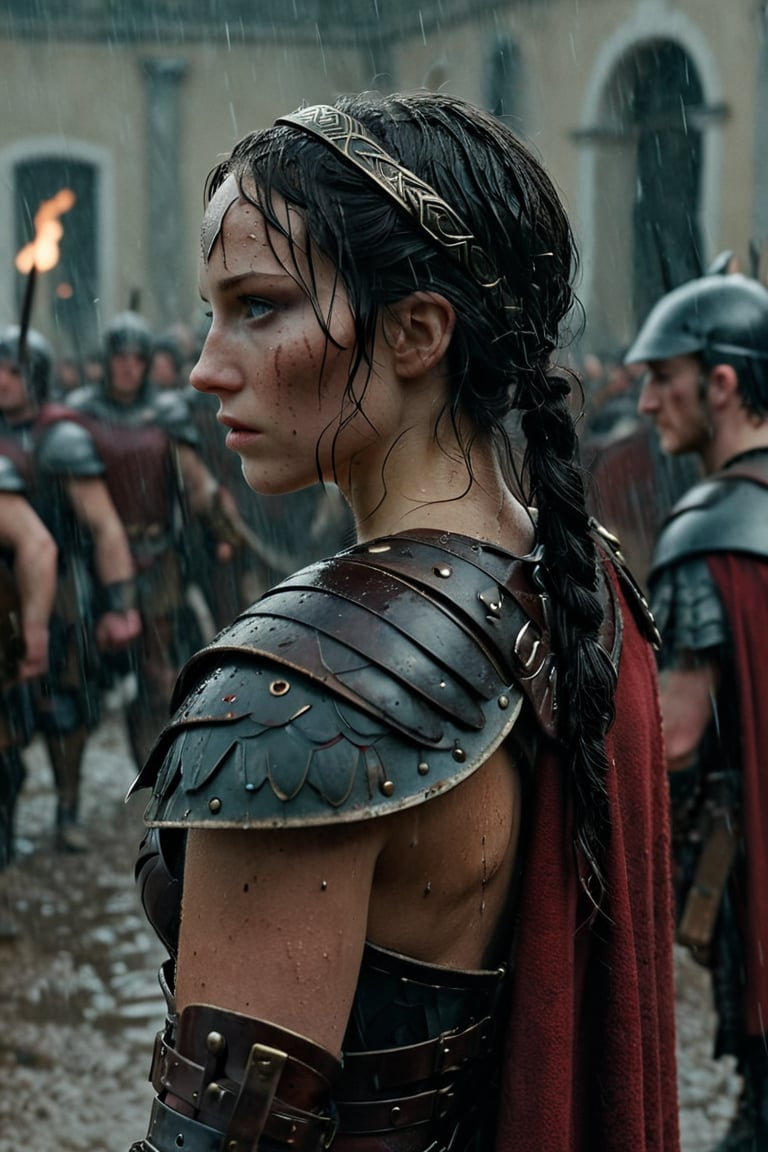

In [ ]:
# @title 🖼️ Upload an image
from google.colab import files
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


colab_image_folder = '/content/text-to-image-prompts/images/'
#Get image
# You can use "http://images.cocodataset.org/val2017/000000039769.jpg" for testing
image_url = "" # @param {"type":"string","placeholder":"leave empty for local upload (scroll down to see it)"}
colab_image_path = "imperial.png" # @param {"type":"string","placeholder": "eval. as '/content/sd_tokens/' + **your input**"}
# @markdown --------------------------

image_path = ""

from PIL import Image
import requests
image_A = ""
#----#
if image_url == "":
  import cv2
  from google.colab.patches import cv2_imshow
  # Open the image.
  if colab_image_path == "":
    keys =  upload_files()
    for key in keys:
      image_A = cv2.imread(colab_image_folder + key)
      colab_image_path = colab_image_folder + key
      image_path = colab_image_folder + key
  else:
    image_A = cv2.imread(colab_image_folder + colab_image_path)
else:
  image_A = Image.open(requests.get(image_url, stream=True).raw)
#------#
from google.colab.patches import cv2_imshow
cv2_imshow(image_A)



In [ ]:
# @title 🖼️ Get image_encoding similarity to the pre-calc. text_encodings

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

# Get image features
inputs = processor(images=image_A, return_tensors="pt")
image_features = model.get_image_features(**inputs)
image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
name_A = "the image"
#-----#

sims = torch.zeros(NUM_VOCAB_ITEMS)
for index in range(NUM_VOCAB_ITEMS):
  text_features =  text_encodings[f'{index}']
  logit_scale = model.logit_scale.exp()
  torch.matmul(text_features, image_features.t()) * logit_scale
  sims[index]  = torch.nn.functional.cosine_similarity(text_features, image_features)
#-------#
sorted , indices = torch.sort(sims,dim=0 , descending=True)

In [ ]:
# @title 🖼️ Print the results
list_size = 100 # @param {type:'number'}
start_at_index = 100 # @param {type:'number'}
print_Similarity = True # @param {type:"boolean"}
print_Prompts = True # @param {type:"boolean"}
print_Prefix = True # @param {type:"boolean"}
print_Descriptions = True # @param {type:"boolean"}
compact_Output = True # @param {type:"boolean"}
newline_Separator = True # @param {type:"boolean"}

# title Show the 100 most similiar suffix and prefix text-encodings to the text encoding
RANGE = list_size
separator = '|'
if newline_Separator : separator = separator + '\n'

_prompts = '{'
_sims =  '{'
for _index in range(start_at_index + RANGE):
  if _index < start_at_index : continue
  index = indices[_index]
  _prompts = _prompts  + prompts[f'{index}'] + separator
  _sims = _sims + f'{round(100*sims[index].item(), 2)} %' + separator
#------#
__prompts = (_prompts + '}').replace(separator + '}', '}')
__sims = (_sims + '}').replace(separator + '}', '}')
#------#

if(not print_Prompts): __prompts = ''
if(not print_Similarity): __sims = ''

if(not compact_Output):
  if(print_Descriptions):
    print(f'The {start_at_index}-{start_at_index + RANGE} most similiar items to prompt : \n\n ' + __prompts)
    print(f'The {start_at_index}-{start_at_index + RANGE} similarity % for items : \n\n' + __sims)
    print('')
  else:
    print(__prompts)
else:
  print(__prompts)
#-------#

In [ ]:
# @title 💫 Compare Text encodings
prompt_A = "banana" # @param {"type":"string","placeholder":"Write a prompt"}
prompt_B = "bike " # @param {"type":"string","placeholder":"Write a prompt"}
use_token_padding = True # param {type:"boolean"} <----- Enabled by default
#-----#
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14",
clean_up_tokenization_spaces = False)
#-----#
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
#----#
inputs = tokenizer(text = prompt_A, padding=True, return_tensors="pt")
text_features_A = model.get_text_features(**inputs)
text_features_A = text_features_A / text_features_A.norm(p=2, dim=-1, keepdim=True)
name_A = prompt_A
#----#
inputs = tokenizer(text = prompt_B, padding=True, return_tensors="pt")
text_features_B = model.get_text_features(**inputs)
text_features_B = text_features_B / text_features_B.norm(p=2, dim=-1, keepdim=True)
name_B = prompt_B
#----#
import torch
sim_AB = torch.nn.functional.cosine_similarity(text_features_A, text_features_B)
#----#
print(f'The similarity between the text_encoding for A:"{prompt_A}" and B: "{prompt_B}" is {round(sim_AB.item()*100,2)} %')

You can write an url or upload a file locally from your device to use as reference. The image will by saved in the 'sd_tokens' folder. Note that the 'sd_tokens' folder will be deleted upon exiting this runtime.

In [ ]:
# @title Make your own text_encodings .safetensor file for later use (using GPU is recommended to speed things up)

import json
import pandas as pd
import os
import shelve
import torch
from safetensors.torch import save_file

using_Kaggle = False #Use https://www.kaggle.com/ if Google Colab GPU is busy

home_directory = '/content/'
if using_Kaggle : home_directory = '/kaggle/working/'
output_folder = home_directory + 'text_encodings/'
target = home_directory + 'text-to-image-prompts/names/celebs/mixed/text'

def my_mkdirs(folder):
    if os.path.exists(folder)==False:
        os.makedirs(folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

%cd {home_directory}


my_mkdirs(home_directory +'text_encodings/')
filename = ''


NUM_FILES = 1
for  file_index in range(NUM_FILES + 1):
    if (file_index < 1): continue
    filename = f'🆔👨 fusion-t2i-v2-celeb-{file_index}'

  # Read suffix.json
    %cd {target}
    with open(filename + '.json', 'r') as f:
        data = json.load(f)
    _df = pd.DataFrame({'count': data})['count']
    prompts = {
        key : value.replace("</w>"," ") for key, value in _df.items()
    }
    NUM_ITEMS = int(prompts["0"])
    #------#

  # Calculate text_encoding for .json file contents and results as .db file

    %cd {output_folder}
    text_encoding_dict = {}
    offset = 0;
    index = 0;
    subby = 1;
    for _index in range(NUM_ITEMS):
      index = _index - offset
      inputs = tokenizer(text = '' + prompts[f'{index}'], padding=True, return_tensors="pt").to(device)
      text_features = model.get_text_features(**inputs).to(device)
      text_features =  text_features/text_features.norm(p=2, dim=-1, keepdim=True)
      text_encoding_dict[f'{index}'] = text_features.to(torch.device('cpu'))
      if (index % 100 == 0) :
        print(index)
      if (index % 1000 == 0) :
        save_file(text_encoding_dict, f'{filename}-{subby}.safetensors')
        offset = offset + index
        subby = subby + 1
        text_encoding_dict = {}
      continue
    save_file(text_encoding_dict, f'{filename}.safetensors')
    #-----#

  #----#

#from safetensors.torch import load_file
#%cd /content/text_encodings
#loaded = load_file('🦜 fusion-t2i-prompt-features-1.safetensors')
#print(loaded["325"])

In [ ]:
# @title Download the text_encodings as .zip
%cd /content/
!zip -r /content/text_encodings.zip /content/text_encodings/

In [ ]:
# @title Merge text_encodings

import json
import pandas as pd
import os
import shelve
import torch
from safetensors.torch import save_file , load_file

def my_mkdirs(folder):
    if os.path.exists(folder)==False:
        os.makedirs(folder)


using_Kaggle = False #Use https://www.kaggle.com/ if Google Colab GPU is busy

home_directory = '/content/'
if using_Kaggle : home_directory = '/kaggle/working/'
output_folder = home_directory +'merged_text_encodings/'
my_mkdirs(f'{output_folder}')

target = home_directory + 'text_encodings'
_filename = f'🆔👨 fusion-t2i-v2-celeb-1'
result = {}
#------#
%cd {target}
for _index in range(5):
  if _index <1:continue
  filename = _filename + f'-{_index}'
  prompts = load_file(filename + '.safetensors')
  for key in prompts:
    index = _index*1000  + int(key)
    result[f'{index}'] = prompts[key]
  #------#
#--------3

%cd {output_folder}
save_file(result, f'{_filename}.safetensors')





In [ ]:
# @title Download the created text_encodings as .zip file
%cd /content/
!zip -r /content/text-encodings.zip /content/text_encodings



# How does this notebook work?

Similiar vectors = similiar output in the SD 1.5 / SDXL / FLUX model

CLIP converts the prompt text to vectors (“tensors”) , with float32 values usually ranging from -1 to 1.

Dimensions are \[ 1x768 ] tensors for SD 1.5 , and a \[ 1x768 , 1x1024 ] tensor for SDXL and FLUX.

The SD models and FLUX converts these vectors to an image.

This notebook takes an input string , tokenizes it and matches the first token against the 49407 token vectors in the vocab.json : [https://huggingface.co/black-forest-labs/FLUX.1-dev/tree/main/tokenizer](https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2Fblack-forest-labs%2FFLUX.1-dev%2Ftree%2Fmain%2Ftokenizer)

It finds the “most similiar tokens” in the list. Similarity is the theta angle between the token vectors.

<div>
<img src="https://huggingface.co/datasets/codeShare/sd_tokens/resolve/main/cosine.jpeg" width="300"/>
</div>

The angle is calculated using cosine similarity , where 1 = 100% similarity (parallell vectors) , and 0 = 0% similarity (perpendicular vectors).

Negative similarity is also possible.

# How can I use it?

If you are bored of prompting “girl” and want something similiar you can run this notebook and use the “chick” token at 21.88% similarity , for example

You can also run a mixed search , like “cute+girl”/2 , where for example “kpop” has a 16.71% similarity

There are some strange tokens further down the list you go. Example: tokens similiar to the token "pewdiepie</w>" (yes this is an actual token that exists in CLIP)

<div>
<img src="https://lemmy.world/pictrs/image/a1cd284e-3341-4284-9949-5f8b58d3bd1f.jpeg" width="300"/>
</div>

Each of these correspond to a unique 1x768 token vector.

The higher the ID value , the less often the token appeared in the CLIP training data.

To reiterate; this is the CLIP model training data , not the SD-model training data.

So for certain models , tokens with high ID can give very consistent results , if the SD model is trained to handle them.

Example of this can be anime models , where japanese artist names can affect the output greatly.  

Tokens with high ID will often give the "fun" output when used in very short prompts.

# What about token vector length?

If you are wondering about token magnitude,
Prompt weights like (banana:1.2) will scale the magnitude of the corresponding 1x768 tensor(s) by 1.2 . So thats how prompt token magnitude works.

Source: [https://huggingface.co/docs/diffusers/main/en/using-diffusers/weighted\_prompts](https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2Fdocs%2Fdiffusers%2Fmain%2Fen%2Fusing-diffusers%2Fweighted_prompts)\*

So TLDR; vector direction = “what to generate” , vector magnitude = “prompt weights”

# How prompting works (technical summary)

 1. There is no correct way to prompt.

2. Stable diffusion reads your prompt left to right, one token at a time, finding association _from_ the previous token _to_ the current token _and to_ the image generated thus far (Cross Attention Rule)

3. Stable Diffusion is an optimization problem that seeks to maximize similarity to prompt and minimize similarity to negatives  (Optimization Rule)

Reference material (covers entire SD , so not good source material really, but the info is there)  : https://youtu.be/sFztPP9qPRc?si=ge2Ty7wnpPGmB0gi

# The SD pipeline

For every step (20 in total by default) for SD1.5 :

1. Prompt text =>  (tokenizer)
2. => Nx768 token vectors =>(CLIP model) =>
3. 1x768 encoding => ( the SD model / Unet ) =>
4. => _Desired_ image per Rule 3 => ( sampler)
5. => Paint a section of the image => (image)

# Disclaimer /Trivia

This notebook should be seen as a "dictionary search tool"  for the vocab.json , which is the same for SD1.5 , SDXL and FLUX. Feel free to verify this by checking the 'tokenizer' folder under each model.

vocab.json in the FLUX model , for example (1 of 2 copies) : https://huggingface.co/black-forest-labs/FLUX.1-dev/tree/main/tokenizer

I'm using Clip-vit-large-patch14 , which is used in SD 1.5 , and is one among the two tokenizers for SDXL and FLUX  : https://huggingface.co/openai/clip-vit-large-patch14/blob/main/README.md

This set of tokens has dimension 1x768.  

SDXL and FLUX uses an additional set of tokens of dimension 1x1024.

These are not included in this notebook. Feel free to include them yourselves (I would appreciate that).

To do so, you will have to download a FLUX and/or SDXL model

, and copy the 49407x1024 tensor list that is stored within the model and then save it as a .pt file.

//---//

I am aware it is actually the 1x768 text_encoding being processed into an image for the SD models + FLUX.

As such , I've included text_encoding comparison at the bottom of the Notebook.

I am also aware thar SDXL and FLUX uses additional encodings , which are not included in this notebook.

* Clip-vit-bigG for SDXL: https://huggingface.co/laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/blob/main/README.md

* And the T5 text encoder for FLUX. I have 0% understanding of FLUX T5 text_encoder.

//---//

If you want them , feel free to include them yourself and share the results (cuz I probably won't)  :)!

That being said , being an encoding , I reckon the CLIP Nx768 => 1x768 should be "linear" (or whatever one might call it)

So exchange a few tokens in the Nx768 for something similiar , and the resulting 1x768 ought to be kinda similar to 1x768 we had earlier. Hopefully.

I feel its important to mention this , in case some wonder why the token-token similarity don't match the text-encoding to text-encoding similarity.

# Note regarding CLIP text encoding vs. token

*To make this disclaimer clear; Token-to-token similarity is not the same as text_encoding similarity.*

I have to say this , since it will  otherwise get (even more) confusing , as both the individual tokens , and the text_encoding have dimensions 1x768.

They are separate things. Separate results. etc.

As such , you will not get anything useful if you start comparing similarity between a token , and a text-encoding. So don't do that :)!

# What about the CLIP image encoding?

The CLIP model can also do an image_encoding of an image, where the output will be a 1x768 tensor. These _can_ be compared with the text_encoding.

Comparing CLIP image_encoding with the CLIP text_encoding for a bunch of random prompts until you find the "highest similarity" , is a method used in the CLIP interrogator : https://huggingface.co/spaces/pharmapsychotic/CLIP-Interrogator

List of random prompts for CLIP interrogator  can be found here, for reference : https://github.com/pharmapsychotic/clip-interrogator/tree/main/clip_interrogator/data

The CLIP image_encoding is not included in this Notebook.

If you spot errors / ideas for improvememts; feel free to fix the code in your own notebook and post the results.

I'd appreciate that over people saying "your math is wrong you n00b!" with no constructive feedback.

//---//

Regarding output

# What are the </w> symbols?

The whitespace symbol indicate if the tokenized item ends with whitespace ( the suffix "banana</w>" => "banana " )  or not (the prefix  "post"  in "post-apocalyptic ")

For ease of reference , I call them prefix-tokens and suffix-tokens.

Sidenote:

Prefix tokens have the unique property in that they "mutate" suffix tokens

Example:  "photo of a #prefix#-banana"

where #prefix# is a randomly selected prefix-token from the vocab.json

The hyphen "-" exists to guarantee the tokenized text splits into the written #prefix# and #suffix# token respectively.  The "-" hypen symbol can be replaced by any other special character of your choosing.

 Capital letters work too , e.g "photo of a #prefix#Abanana" since the capital letters A-Z are only listed once in the entire vocab.json.

You can also choose to omit any separator and just rawdog it with the prompt "photo of a #prefix#banana" , however know that  this may , on occasion , be tokenized as completely different tokens of lower ID:s.

Curiously , common NSFW terms found online have in the CLIP model have been purposefully fragmented into separate #prefix# and #suffix# counterparts in the vocab.json. Likely for PR-reasons.

You can verify the results using this online tokenizer: https://sd-tokenizer.rocker.boo/

<div>
<img src="https://lemmy.world/pictrs/image/43467d75-7406-4a13-93ca-cdc469f944fc.jpeg" width="300"/>
<img src="https://lemmy.world/pictrs/image/c0411565-0cb3-47b1-a788-b368924d6f17.jpeg" width="300"/>
<img src="https://lemmy.world/pictrs/image/c27c6550-a88b-4543-9bd7-067dff016be2.jpeg" width="300"/>
</div>

# What is that gibberish tokens that show up?

The gibberish tokens like "ðŁĺħ\</w>" are actually emojis!

Try writing some emojis in this online tokenizer to see the results: https://sd-tokenizer.rocker.boo/

It is a bit borked as it can't process capital letters properly.

Also note that this is not reversible.

If tokenization "😅" => ðŁĺħ</w>

Then you  can't prompt "ðŁĺħ" and expect to get the same result as the tokenized original emoji , "😅".

SD 1.5 models actually have training for Emojis.

But you have to set CLIP skip to 1 for this to work is intended.

For example, this is the result from "photo of a 🧔🏻‍♂️"


<div>
<img src="https://lemmy.world/pictrs/image/e2b51aea-6960-4ad0-867e-8ce85f2bd51e.jpeg" width="300"/>
</div>

A tutorial on stuff you can do with the vocab.list concluded.

Anyways, have fun with the notebook.

There might be some updates in the future with features not mentioned here.

//---//

https://codeandlife.com/2023/01/26/mastering-the-huggingface-clip-model-how-to-extract-embeddings-and-calculate-similarity-for-text-and-images/

https://arxiv.org/pdf/2303.03032

In [ ]:
# @title Deprecated
prompt = " a fast car on the road " # @param {"type":"string","placeholder":"Write a prompt"}

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

# Get text features for user input
inputs = tokenizer(text = prompt, padding=True, return_tensors="pt")
text_features_A = model.get_text_features(**inputs)
text_features_A = text_features_A/text_features_A.norm(p=2, dim=-1, keepdim=True)
name_A = prompt
#------#

# Load the .db file for prefix encodings
import shelve
_iters = -1
RANGE = NUM_PREFIX
NUM_PREFIX_LISTS = 1
dots = results_sim = torch.zeros(RANGE*NUM_PREFIX_LISTS)
for _PREFIX_ENC_VOCAB in PREFIX_ENC_VOCAB:
  _iters = _iters + 1
  d = shelve.open(_PREFIX_ENC_VOCAB)
  for _index in range(RANGE):
    index = _iters*RANGE + _index
    text_features =  text_encodings[f'{_index}']
    sim = torch.nn.functional.cosine_similarity(text_features, text_features_A)
    dots[index] = sim
  #----#
  d.close() #close the file
#------#
prefix_sorted, prefix_indices = torch.sort(dots,dim=0 , descending=True)
#------#


_prefixes = '{'
for index in range(start_at_index + RANGE):
  if index < start_at_index : continue
  id = f'{prefix_indices[index]}'
  #sim = prefix_sorted[index]
  name = get_prefix(id)
  _prefixes = _prefixes + name + '|'
#------#
_prefixes = (_prefixes + '}').replace('|}', '}')


prefixes = _prefixes
if(not print_Prefix): prefixes = ''

if(print_Descriptions):
  print(f'The {start_at_index}-{start_at_index + RANGE} most similiar prefixes to prompt : ' + prefixes)
else:
  if(compact_Output):
    print((prefixes + _suffixes).replace('}{', '|'))
  else:
    print(prefixes)

# @title ✳️ Load/initialize values
# Load the tokens into the colab
!git clone https://huggingface.co/datasets/codeShare/sd_tokens
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch import linalg as LA
%cd /content/sd_tokens
token = torch.load('sd15_tensors.pt', map_location= torch.device('cpu'), weights_only=True)
#-----#
VOCAB_FILENAME = 'tokens_most_similiar_to_girl'
ACTIVE_IMG = ''
#-----#

# Define functions/constants
NUM_TOKENS = 49407
NUM_PREFIX = 13662
NUM_SUFFIX = 32901

PREFIX_ENC_VOCAB = ['encoded_prefix_to_girl',]
SUFFIX_ENC_VOCAB = ['a_-_encoded_suffix' ,]
    #'from_-encoded_suffix',
    #'by_-encoded_suffix' ,
    #'encoded_suffix-_like']

# Make sure these match above results
NUM_PREFIX_LISTS = len(PREFIX_ENC_VOCAB)
NUM_SUFFIX_LISTS = len(SUFFIX_ENC_VOCAB)
#-----#


#Import the vocab.json
import json
import pandas as pd

# Read suffix.json
with open('suffix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
suffix = {
    key : value for key, value in _df.items()
}
# Read prefix json
with open('prefix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
prefix = {
    key : value for key, value in _df.items()
}

# Read to_suffix.json
with open('to_suffix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
suffix_to_vocab = {
    key : value for key, value in _df.items()
}

# Read to_prefix.json
with open('to_prefix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
prefix_to_vocab = {
    key : value for key, value in _df.items()
}

#-----#


# Read to_suffix.json (reversing key and value)
with open('to_suffix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
vocab_to_suffix = {
    value : key for key, value in _df.items()
}

# Read to_prefix.json (reversing key and value)
with open('to_prefix.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
vocab_to_prefix = {
    value : key for key, value in _df.items()
}


#-----#

#get token from id (excluding tokens with special symbols)
def vocab(id):
  _id = f'{id}'
  if _id in vocab_to_suffix:
    _id = vocab_to_suffix[_id]
    return suffix[_id]
  if _id in vocab_to_prefix:
    _id = vocab_to_prefix[_id]
    return prefix[_id]
  return ' ' #<---- return whitespace if other id like emojis etc.
#--------#

#get token from id (excluding tokens with special symbols)
def get_suffix(id):
  _id = f'{id}'
  if int(id) <= NUM_SUFFIX:
    return suffix[_id]
  return ' ' #<---- return whitespace if out of bounds
#--------#

#get token from id (excluding tokens with special symbols)
def get_prefix(id):
  _id = f'{id}'
  if int(id) <= NUM_PREFIX:
    return prefix[_id]
  return ' ' #<---- return whitespace if out of bounds
#--------#


def _modulus(_id,id_max):
  id = _id
  while(id>id_max):
    id = id-id_max
  return id

#print(get_token(35894))


In [ ]:
# @title ⚡ Get similiar tokens (not updated yet)
import torch
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)

# @markdown Write name of token to match against
token_name = "banana " # @param {type:'string',"placeholder":"leave empty for random value token"}

prompt = token_name
# @markdown (optional) Mix the token with something else
mix_with = "" # @param {"type":"string","placeholder":"leave empty for random value token"}
mix_method = "None" # @param ["None" , "Average", "Subtract"] {allow-input: true}
w = 0.5 # @param {type:"slider", min:0, max:1, step:0.01}
# @markdown Limit char size of included token

min_char_size = 0 # param {type:"slider", min:0, max: 50, step:1}
char_range = 50 # param {type:"slider", min:0, max: 50, step:1}

tokenizer_output = tokenizer(text = prompt)
input_ids = tokenizer_output['input_ids']
id_A = input_ids[1]
A = torch.tensor(token[id_A])
A = A/A.norm(p=2, dim=-1, keepdim=True)
#-----#
tokenizer_output = tokenizer(text = mix_with)
input_ids = tokenizer_output['input_ids']
id_C = input_ids[1]
C = torch.tensor(token[id_C])
C = C/C.norm(p=2, dim=-1, keepdim=True)
#-----#
sim_AC = torch.dot(A,C)
#-----#
print(input_ids)
#-----#

#if no imput exists we just randomize the entire thing
if (prompt == ""):
  id_A = -1
  print("Tokenized prompt tensor A is a random valued tensor with no ID")
  R = torch.rand(A.shape)
  R = R/R.norm(p=2, dim=-1, keepdim=True)
  A = R
  name_A = 'random_A'

#if no imput exists we just randomize the entire thing
if (mix_with == ""):
  id_C = -1
  print("Tokenized prompt  'mix_with' tensor C is a random valued tensor with no ID")
  R = torch.rand(A.shape)
  R = R/R.norm(p=2, dim=-1, keepdim=True)
  C = R
  name_C = 'random_C'

name_A = "A of random type"
if (id_A>-1):
  name_A = vocab(id_A)

name_C = "token C of random type"
if (id_C>-1):
  name_C = vocab(id_C)

print(f"The similarity between A '{name_A}' and C '{name_C}' is {round(sim_AC.item()*100,2)} %")

if (mix_method ==  "None"):
  print("No operation")

if (mix_method ==  "Average"):
  A = w*A + (1-w)*C
  _A = LA.vector_norm(A, ord=2)
  print(f"Tokenized prompt tensor A '{name_A}' token has been recalculated as A = w*A + (1-w)*C , where C is '{name_C}' token , for w = {w}  ")

if (mix_method ==  "Subtract"):
  tmp =  w*A - (1-w)*C
  tmp = tmp/tmp.norm(p=2, dim=-1, keepdim=True)
  A = tmp
  #//---//
  print(f"Tokenized prompt tensor A '{name_A}' token has been recalculated as A = _A*norm(w*A  - (1-w)*C) , where C is '{name_C}' token , for w = {w} ")

#OPTIONAL : Add/subtract + normalize above result with another token. Leave field empty to get a random value tensor

dots = torch.zeros(NUM_TOKENS)
for index in range(NUM_TOKENS):
  id_B = index
  B = torch.tensor(token[id_B])
  B = B/B.norm(p=2, dim=-1, keepdim=True)
  sim_AB = torch.dot(A,B)
  dots[index] = sim_AB


sorted, indices = torch.sort(dots,dim=0 , descending=True)
#----#
if (mix_method ==  "Average"):
  print(f'Calculated all cosine-similarities between the average of token {name_A} and {name_C} with Id_A = {id_A} and mixed Id_C = {id_C} as a 1x{sorted.shape[0]} tensor')
if (mix_method ==  "Subtract"):
  print(f'Calculated all cosine-similarities between the subtract of token {name_A} and {name_C} with Id_A = {id_A} and mixed Id_C = {id_C} as a 1x{sorted.shape[0]} tensor')
if (mix_method ==  "None"):
  print(f'Calculated all cosine-similarities between the token {name_A} with Id_A = {id_A} with the the rest of the {NUM_TOKENS} tokens as a 1x{sorted.shape[0]} tensor')

#Produce a list id IDs that are most similiar to the prompt ID at positiion 1 based on above result

# @markdown Set print options
list_size = 100 # @param {type:'number'}
print_ID = False # @param {type:"boolean"}
print_Similarity = True # @param {type:"boolean"}
print_Name = True # @param {type:"boolean"}
print_Divider = True # @param {type:"boolean"}


if (print_Divider):
  print('//---//')

print('')
print('Here is the result : ')
print('')

for index in range(list_size):
  id = indices[index].item()
  if (print_Name):
    print(f'{vocab(id)}') # vocab item
  if (print_ID):
    print(f'ID = {id}') # IDs
  if (print_Similarity):
    print(f'similiarity = {round(sorted[index].item()*100,2)} %')
  if (print_Divider):
    print('--------')

#Print the sorted list from above result

#The prompt will be enclosed with the <|start-of-text|> and <|end-of-text|> tokens, which is why output will be [49406, ... , 49407].

#You can leave the 'prompt' field empty to get a random value tensor. Since the tensor is random value, it will not correspond to any tensor in the vocab.json list , and this it will have no ID.

# Save results as .db file
import shelve
VOCAB_FILENAME = 'tokens_most_similiar_to_' + name_A.replace('</w>','').strip()
d = shelve.open(VOCAB_FILENAME)
#NUM TOKENS == 49407
for index in range(NUM_TOKENS):
  #print(d[f'{index}']) #<-----Use this to read values from the .db file
  d[f'{index}']= vocab(indices[index].item()) #<---- write values to .db file
#----#
d.close() #close the file
# See this link for additional stuff to do with shelve: https://docs.python.org/3/library/shelve.html

In [ ]:

# @title Create random names from firstname and lastnames
import random
import json
import pandas as pd
import os
import shelve
import torch
from safetensors.torch import save_file

def my_mkdirs(folder):
  if os.path.exists(folder)==False:
    os.makedirs(folder)


my_mkdirs('/content/female_full_names/')
filename = ''

filename = '🆔👩_🦰 fusion-t2i-girl-firstname-1'
%cd /content/text-to-image-prompts/names/firstnames/text
with open(filename + '.json', 'r') as f:
    data = json.load(f)
_df = pd.DataFrame({'count': data})['count']
firstname = {
    key : value for key, value in _df.items()
}

NUM_FIRSTNAME = 100901


NUM_FILES = 9
for  file_index in range(NUM_FILES + 1):
  if file_index <1: continue
  #if file_index >4: break
  filename = f'👱_♀️ fusion-t2i-lastnames-{file_index} plugin'
  #🦜 fusion-t2i-prompt-features-1.json

  # Read suffix.json
  %cd /content/text-to-image-prompts/names/lastnames/text
  with open(filename + '.json', 'r') as f:
      data = json.load(f)
  _df = pd.DataFrame({'count': data})['count']
  names = {
      key : firstname[f'{random.randint(2,NUM_FIRSTNAME)}'] + ' ' f'{value}' + ' ' for key, value in _df.items()
  }

  index = 0

  for key in names:
    index = index + 1
  #-----#
  RANGE = min(index,1000)
  output = {}

  for index in range(RANGE):
    if index >1000: break
    output[f'{index}'] = names[f'{index}']
  #-----#
  output[f'{1}'] = f'👱_♀️female_fullnames-{file_index}'
  output[f'{0}'] = f'{RANGE}'
  txt_filename = f'👱_♀️female_fullnames-{file_index}'
  %cd /content/female_full_names/
  with open(txt_filename + '.txt', 'w') as f:
    f.write(str(output))

  #files.download(f'fullnames-{file_index}.txt')

#firstname[f'{random.randint(2,NUM_FIRSTNAME)}'] + f'{value}'

  #------#




In [5]:
# @title Download the created text_encodings as .zip file
%cd /content/
!zip -r /content/female_full_names.zip /content/female_full_names/

/content
  adding: content/female_full_names/ (stored 0%)
  adding: content/female_full_names/👱_♀️female_fullnames-3.txt (deflated 66%)
  adding: content/female_full_names/👱_♀️female_fullnames-8.txt (deflated 66%)
  adding: content/female_full_names/👱_♀️female_fullnames-1.txt (deflated 67%)
  adding: content/female_full_names/👱_♀️female_fullnames-9.txt (deflated 67%)
  adding: content/female_full_names/👱_♀️female_fullnames-2.txt (deflated 67%)
  adding: content/female_full_names/👱_♀️female_fullnames-6.txt (deflated 67%)
  adding: content/female_full_names/👱_♀️female_fullnames-5.txt (deflated 67%)
  adding: content/female_full_names/👱_♀️female_fullnames-4.txt (deflated 66%)
  adding: content/female_full_names/👱_♀️female_fullnames-7.txt (deflated 65%)


In [ ]:
# @title ⚡+🖼️ -> 📝 Token-Sampling Image interrogator (work in progress)
#-----#
NUM_TOKENS = 49407
import shelve
db_vocab = shelve.open(VOCAB_FILENAME)
print(f'using the tokens found in {VOCAB_FILENAME}.db as the vocab')
# @markdown # What do you want to to mimic?
use = '🖼️image_encoding from image' # @param ['📝text_encoding from prompt', '🖼️image_encoding from image']
# @markdown --------------------------
use_token_padding = True # param {type:"boolean"} <---- Enabled by default
prompt = "photo of a banana" # @param {"type":"string","placeholder":"Write a prompt"}
#-----#
prompt_A = prompt
if(image_path != "") : image_A = cv2.imread("/content/sd_tokens/" + image_path)
#-----#

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14", clean_up_tokenization_spaces = False)
from transformers import  CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14" , clean_up_tokenization_spaces = True)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
#-----#
if(use == '🖼️image_encoding from image'):
  # Get image features
  inputs = processor(images=image_A, return_tensors="pt")
  image_features = model.get_image_features(**inputs)
  image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
  name_A = "the image"
#-----#
if(use == '📝text_encoding from prompt'):
  # Get text features
  inputs = tokenizer(text = prompt, padding=True, return_tensors="pt")
  text_features_A = model.get_text_features(**inputs)
  name_A = prompt
#-----#
# @markdown # The output...
must_start_with = "" # @param {"type":"string","placeholder":"write a text"}
must_contain = "" # @param {"type":"string","placeholder":"write a text"}
must_end_with = "" # @param {"type":"string","placeholder":"write a text"}
# @markdown -----
# @markdown # Use a range of tokens from the vocab.json (slow method)
start_search_at_index = 0 # @param {type:"slider", min:0, max: 49407, step:100}
# @markdown The lower the start_index, the more similiar the sampled tokens will be to the target token assigned in the '⚡ Get similiar tokens' cell". If the cell was not run, then it will use tokens ordered by similarity to the "girl\</w>" token
start_search_at_ID = start_search_at_index
search_range = 1000 # @param {type:"slider", min:100, max:49407, step:100}

samples_per_iter = 10 # @param {type:"slider", min:10, max: 100, step:10}

iterations = 5 # @param {type:"slider", min:1, max: 20, step:0}
restrictions = 'None' # @param ["None", "Suffix only", "Prefix only"]
#markdown Limit char size of included token <----- Disabled
min_char_size = 0 #param {type:"slider", min:0, max: 20, step:1}
char_range = 50 #param {type:"slider", min:0, max: 20, step:1}
# markdown # ...or paste prompt items
# markdown Format must be {item1|item2|...}. You can aquire prompt items using the Randomizer in the fusion gen: https://perchance.org/fusion-ai-image-generator
_enable = False # param {"type":"boolean"}
prompt_items = "" # param {"type":"string","placeholder":"{item1|item2|...}"}
#-----#
#-----#
START = start_search_at_ID
RANGE =  min(search_range , max(1,NUM_TOKENS - start_search_at_ID))
#-----#
import math, random
NUM_PERMUTATIONS = 6
ITERS = iterations
#-----#
#LOOP START
#-----#
# Check if original solution is best
best_sim = 0
name = must_start_with + must_contain + must_end_with
ids = processor.tokenizer(text=name, padding=use_token_padding, return_tensors="pt")
text_features = model.get_text_features(**ids)
text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
#------#
sim = 0
if(use == '🖼️image_encoding from image'):
  logit_scale = model.logit_scale.exp()
  torch.matmul(text_features, image_features.t()) * logit_scale
  sim = torch.nn.functional.cosine_similarity(text_features, image_features) * logit_scale
#-----#
if(use == '📝text_encoding from prompt'):
  sim = torch.nn.functional.cosine_similarity(text_features, text_features_A)
#-----#
best_sim = sim
best_name = name
name_B = must_contain
#------#
results_sim = torch.zeros(ITERS*NUM_PERMUTATIONS)
results_name_B = {}
results_name = {}
#-----#
for iter in range(ITERS):
  dots = torch.zeros(min(list_size,RANGE))
  is_trail = torch.zeros(min(list_size,RANGE))

  #-----#

  for index in range(samples_per_iter):
    _start = START
    id_C = random.randint(_start , _start + RANGE)
    name_C = db_vocab[f'{id_C}']
    is_Prefix = 0
    #Skip if non-AZ characters are found
    #???
    #-----#
    # Decide if we should process prefix/suffix tokens
    if name_C.find('</w>')<=-1:
      is_Prefix = 1
      if restrictions != "Prefix only":
        continue
    else:
      if restrictions == "Prefix only":
        continue
    #-----#
    # Decide if char-size is within range
    if len(name_C) < min_char_size:
      continue
    if len(name_C) > min_char_size + char_range:
      continue
    #-----#
    name_CB = must_start_with + name_C + name_B + must_end_with
    if is_Prefix>0:
      name_CB = must_start_with + ' ' + name_C + '-' + name_B + ' ' + must_end_with
    #-----#
    if(use == '🖼️image_encoding from image'):
      ids_CB = processor.tokenizer(text=name_CB, padding=use_token_padding, return_tensors="pt")
      text_features = model.get_text_features(**ids_CB)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      logit_scale = model.logit_scale.exp()
      torch.matmul(text_features, image_features.t()) * logit_scale
      sim_CB = torch.nn.functional.cosine_similarity(text_features, image_features) * logit_scale
    #-----#
    if(use == '📝text_encoding from prompt'):
      ids_CB = processor.tokenizer(text=name_CB, padding=use_token_padding, return_tensors="pt")
      text_features = model.get_text_features(**ids_CB)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      sim_CB = torch.nn.functional.cosine_similarity(text_features, text_features_A)
    #-----#
    #-----#
    if restrictions == "Prefix only":
      result = sim_CB
      result = result.item()
      dots[index] = result
      continue
    #-----#
    if(use == '🖼️image_encoding from image'):
      name_BC = must_start_with + name_B + name_C + must_end_with
      ids_BC = processor.tokenizer(text=name_BC, padding=use_token_padding, return_tensors="pt")
      text_features = model.get_text_features(**ids_BC)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      logit_scale = model.logit_scale.exp()
      torch.matmul(text_features, image_features.t()) * logit_scale
      sim_BC = torch.nn.functional.cosine_similarity(text_features, image_features) * logit_scale
    #-----#
    if(use == '📝text_encoding from prompt'):
      name_BC = must_start_with + name_B + name_C + must_end_with
      ids_BC = processor.tokenizer(text=name_BC, padding=use_token_padding, return_tensors="pt")
      text_features = model.get_text_features(**ids_BC)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      sim_BC = torch.nn.functional.cosine_similarity(text_features, text_features_A)
    #-----#
    result = sim_CB
    if(sim_BC > sim_CB):
      is_trail[index] = 1
      result = sim_BC
    #-----#
    #result = absolute_value(result.item())
    result = result.item()
    dots[index] = result
  #----#
  sorted, indices = torch.sort(dots,dim=0 , descending=True)
  # @markdown ----------
  # @markdown # Print options
  list_size = 100 # param {type:'number'}
  print_ID = False # @param {type:"boolean"}
  print_Similarity = True # @param {type:"boolean"}
  print_Name = True # @param {type:"boolean"}
  print_Divider = True # @param {type:"boolean"}
  print_Suggestions = False # @param {type:"boolean"}
  #----#
  if (print_Divider):
    print('//---//')
  #----#
  print('')

  used_reference = f'the text_encoding for {prompt_A}'
  if(use == '🖼️image_encoding from image'):
    used_reference = 'the image input'
  print(f'These token pairings within the range ID = {_start} to ID = {_start + RANGE} most closely match {used_reference}: ')
  print('')
  #----#
  aheads = "{"
  trails = "{"
  tmp = ""
  #----#
  max_sim_ahead = 0
  max_sim_trail = 0
  sim = 0
  max_name_ahead = ''
  max_name_trail = ''
  #----#
  for index in range(min(list_size,RANGE)):
    id = _start + indices[index].item()
    name = db_vocab[f'{id}']
    #-----#
    if (name.find('</w>')<=-1):
      name = name + '-'
    if(is_trail[index]>0):
      trails = trails + name + "|"
    else:
      aheads = aheads + name + "|"
    #----#
    sim = sorted[index].item()
    #----#
    if(is_trail[index]>0):
      if sim>max_sim_trail:
        max_sim_trail = sim
        max_name_trail = name
        max_name_trail = max_name_trail.strip()

    else:
      if sim>max_sim_ahead:
        max_sim_ahead = sim
        max_name_ahead = name
  #------#
  trails = (trails + "&&&&").replace("|&&&&", "}").replace("</w>", " ").replace("{&&&&", "")
  aheads = (aheads + "&&&&").replace("|&&&&", "}").replace("</w>", " ").replace("{&&&&", "")
  #-----#

  if(print_Suggestions):
    print(f"place these items ahead of prompt :  {aheads}")
    print("")
    print(f"place these items behind the prompt : {trails}")
    print("")

  tmp = must_start_with + ' ' + max_name_ahead + name_B + ' ' + must_end_with
  tmp = tmp.strip().replace('</w>', ' ')
  print(f"max_similarity_ahead = {round(max_sim_ahead,2)} % when using '{tmp}' ")
  print("")
  tmp = must_start_with + ' ' + name_B + max_name_trail + ' ' + must_end_with
  tmp = tmp.strip().replace('</w>', ' ')
  print(f"max_similarity_trail = {round(max_sim_trail,2)} % when using '{tmp}' ")
  #-----#
  #STEP 2
  import random
  #-----#
  for index in range(NUM_PERMUTATIONS):
    name_inner = ''
    if index == 0 : name_inner = name_B
    if index == 1: name_inner = max_name_ahead
    if index == 2: name_inner = max_name_trail
    if index == 3: name_inner = name_B + max_name_trail
    if index == 4: name_inner = max_name_ahead + name_B
    if index == 5: name_inner = max_name_ahead + name_B + max_name_trail
    if name_inner == '': name_inner = max_name_ahead + name_B + max_name_trail

    name = must_start_with  + name_inner + must_end_with
    #----#
    ids = processor.tokenizer(text=name, padding=use_token_padding, return_tensors="pt")
    #----#
    sim = 0
    if(use == '🖼️image_encoding from image'):
      text_features = model.get_text_features(**ids)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      logit_scale = model.logit_scale.exp()
      torch.matmul(text_features, image_features.t()) * logit_scale
      sim = torch.nn.functional.cosine_similarity(text_features, image_features) * logit_scale
    #-----#
    if(use == '📝text_encoding from prompt'):
      text_features = model.get_text_features(**ids)
      text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
      sim = torch.nn.functional.cosine_similarity(text_features, text_features_A)
    #-----#
    results_name[iter*NUM_PERMUTATIONS + index] = name
    results_sim[iter*NUM_PERMUTATIONS + index] = sim
    results_name_B[iter*NUM_PERMUTATIONS + index] = name_inner.replace('</w>',' ')
  #------#
  #name_B  = results_name_B[iter*NUM_PERMUTATIONS + random.randint(0,3)]
  tmp = iter*NUM_PERMUTATIONS
  _name_B=''
  if results_sim[tmp+1]>results_sim[tmp+2]: _name_B = results_name_B[tmp + 3]
  if results_sim[tmp+2]>results_sim[tmp+1]: _name_B = results_name_B[tmp + 4]

  if _name_B != name_B:
    name_B=_name_B
  else:
    name_B = results_name_B[tmp + 5]

#--------#
print('')
if(use == '🖼️image_encoding from image'  and colab_image_path != ""):
  from google.colab.patches import cv2_imshow
  cv2_imshow(image_A)
#-----#
print('')
sorted, indices = torch.sort(results_sim,dim=0 , descending=True)

for index in range(ITERS*NUM_PERMUTATIONS):
  name_inner = results_name[indices[index].item()]
  print(must_start_with  + name_inner + must_end_with)
  print(f'similiarity = {round(sorted[index].item(),2)} %')
  print('------')
#------#
db_vocab.close() #close the file